In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
omp = 1
mpi_run = 'mpirun -np 8'

# RT analysis of GaAs

This notebook contains the RT analysis of the GaAs performed with Yambo. In particular

* Construction of the RT SAVE folder using ypp
* Definition of the Dataset with the RT computations

We select the source_dir used to generate the base SAVE folder and the associated Yambo run_dir

In [4]:
#source_dir = 'NSCF/bnds_16-kpoints_8.save'
source_dir = 'NSCF/bnds_16-kpoints_4.save'

#run_dir = 'RT_k8'
run_dir = 'RT_k4'

## Construction of the FixSymm folder

The first step of this procedure is represented by the construction of the Yambo run_dir with the SAVE directory. 



In [5]:
U.build_SAVE(source_dir,run_dir,make_link=True)

Create folder RT_k4
Executing command: cd NSCF/bnds_16-kpoints_4.save; p2y -a 2
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/NON EQUILIBRIUM/TiSPiEGA-Project/Analysis/NSCF/bnds_16-kpoints_4.save/SAVE in RT_k4
Executing command: cd RT_k4;OMP_NUM_THREADS=1 yambo


Perform the fixSymm procedure to build the SAVE folder for the RT analysis

In [7]:
fixSymm_inp = I.YamboInput('ypp -y',folder=run_dir)
fixSymm_inp.removeTimeReversal()
fixSymm_inp.set_ypp_extFields(Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
#fixSymm_inp

In [8]:
code = C.YamboCalculator(mpi_run='mpirun -np 1',executable='ypp',skip=False)

Initialize a parallel Yambo calculator with scheduler direct


In [9]:
code.run(inputs=[fixSymm_inp],names=['FixSymm'],run_dir=run_dir)

Executing command: cd RT_k4; mpirun -np 1 ypp -F FixSymm.in -J FixSymm -C FixSymm
run0_is_running:True  
Job completed


{'output': [[]], 'dbs': ['RT_k4/FixSymm']}

Run yambo_rt in the FixSymm folder to build the r_setup

In [10]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
command = 'cd %s; yambo_rt'%rt_run_dir
os.system(command)

0

## RT calculations

We build the input(s) and run the calculations for the RT analysis. 

First of all we identify the run_dir for RT analysis and (if needed) we change the name of the ns.kb_pp_pwscf database to non-local
contributions of the psp

In [5]:
rt_run_dir = os.path.join(run_dir,'FixSymm')
rt_run_dir

'RT_k4/FixSymm'

In [12]:
db = 'ns.kb_pp_pwscf'
src = os.path.join(rt_run_dir,'SAVE',db)
dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
command = 'mv %s %s'%(src,dst)
print(command)
os.system(command)

mv RT_k4/FixSymm/SAVE/ns.kb_pp_pwscf RT_k4/FixSymm/SAVE/ns.kb_pp_pwscf_hide


0

We define the basic elements of the input file

In [8]:
#field parameters
field_int = 1000.0 #kWLm2
field_width = 100 #fs
field_pol = 'circular'
field_freq = 1.55 #eV

# system parameters
bands = [3,10] # from the split-off bands (3,4) to the first conduction bands (9,10)
scissor = 0.5467 # eV (taken from QE_Analysis it gives a direct gap of 1.42 eV)
deph_val  = 0.002 # eV # the sum of the dephasings is 1/10 of the field spread
deph_cond = deph_val# eV

# simulation parameters
time_step = 10 #as
sim_time = 6*field_width # fs
k_parallel = 8

In [9]:
rt_input = I.YamboInput('yambo_rt -n p -v ip -V qp',folder=rt_run_dir)
#rt_input.set_extendOut()
rt_input.set_rt_field(int=field_int,width=field_width,polarization=field_pol,freq=field_freq)
rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=deph_val,damping_conduction=deph_cond)
rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
rt_input.set_rt_cpu(k_parallel)
rt_input

{'args': 'yambo_rt -n p -v ip -V qp',
 'folder': 'RT_k4/FixSymm',
 'filename': 'yambo.in',
 'arguments': ['negf'],
 'variables': {'RT_Threads': [0.0, ''],
  'FFTGvecs': [4279.0, 'RL'],
  'GfnQP_N': [1.0, ''],
  'GfnQP_Wv_E': [0.0, 'eV'],
  'GfnQP_Wv_dos': [0.0, 'eV'],
  'GfnQP_Wc_E': [0.0, 'eV'],
  'GfnQP_Wc_dos': [0.0, 'eV'],
  'PhLifeTime': [0.0, 'fs'],
  'RTstep': [10, 'as'],
  'NETime': [600, 'fs'],
  'Field1_Int': [1000.0, 'kWLm2'],
  'Field1_Width': [100, 'fs'],
  'Field1_Tstart': [0.0, 'fs'],
  'HXC_Potential': 'IP',
  'GfnQPdb': 'none',
  'Integrator': 'RK2',
  'Field1_kind': 'QSSIN',
  'Field1_pol': 'circular',
  'GfnQP_Z': [(1+0j), ''],
  'GfnQP_E': [[0.5467, 1.0, 1.0], ''],
  'GfnQP_Wv': [[0.002, 0.0, 0.0], ''],
  'GfnQP_Wc': [[0.002, 0.0, 0.0], ''],
  'RTBands': [[3, 10], ''],
  'IOtime': [[1.0, 5.0, 1.0], 'fs'],
  'Field1_Freq': [[1.55, 1.55], 'eV'],
  'Field1_Dir': [[1.0, 0.0, 0.0], ''],
  'Field1_Dir_circ': [[0.0, 1.0, 0.0], ''],
  'RT_CPU': '8.1.1.1'}}

In [32]:
code = C.YamboCalculator(omp=omp,mpi_run=mpi_run,executable='yambo_rt',skip=True,verbose=True)
#code.global_options()

Initialize a parallel Yambo calculator with scheduler direct


Now we can perform various computations

### Single computation. Analysis of the time dependence of the spin magnetization

Eventually the basic parameters of the rt_input can be modified and then we perform a single computation.

The relevant parameters used as input are stored in the name of the input (and in the folder that contains the output
files and the database)

In [33]:
idd = {'simTime':sim_time,'dephase':deph_val,'int':field_int,'freq':field_freq}
name = D.name_from_id(idd)

In [34]:
result = code.run(inputs=[rt_input],names=[name],run_dir=rt_run_dir)
result

Skip the computation for input dephase_0.002-freq_1.55-int_1000.0-simTime_600
Job completed


{'output': [['RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.spin_magnetization',
   'RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.orbt_magnetization',
   'RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.external_field',
   'RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.current',
   'RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.carriers',
   'RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600/o-dephase_0.002-freq_1.55-int_1000.0-simTime_600.polarization']],
 'dbs': ['RT_k4/FixSymm/dephase_0.002-freq_1.55-int_1000.0-simTime_600']}

In [35]:
from mppi import Parsers as P

In [36]:
data = P.YamboParser(result['output'][0])

In [37]:
data.keys()

dict_keys(['spin_magnetization', 'orbt_magnetization', 'external_field', 'current', 'carriers', 'polarization'])

In [38]:
field = data['external_field']
carriers = data['carriers']
spin = data['spin_magnetization']

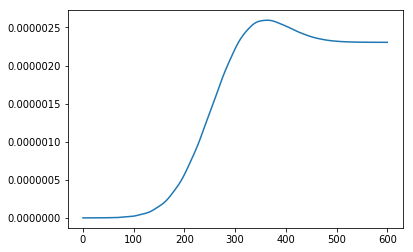

In [23]:
plt.plot(carriers['time'],carriers['dne'])

In [25]:
field.keys()

dict_keys(['time', 'Ex_Re', 'Ey_Re', 'Ez_Re', 'Ex_Im', 'Ey_Im', 'Ez_Im', 'Intensity', 'Fluence'])

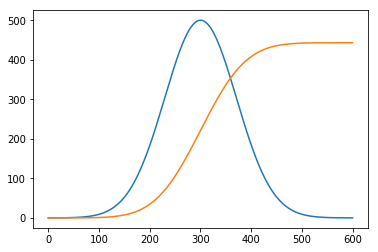

In [40]:
plt.plot(field['time'],field['Intensity'])
plt.plot(field['time'],5*field['Fluence'])

In [29]:
spin.keys()

dict_keys(['time', 'Ms_x', 'Ms_y', 'Ms_z', 'Mv_x', 'Mv_y', 'Mv_z', 'Mc_x', 'Mc_y', 'Mc_z'])

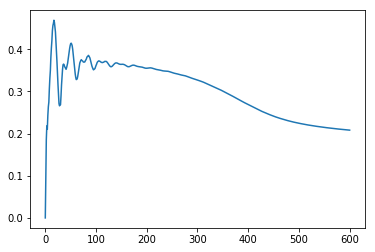

In [31]:
plt.plot(spin['time'],spin['Mc_z'])